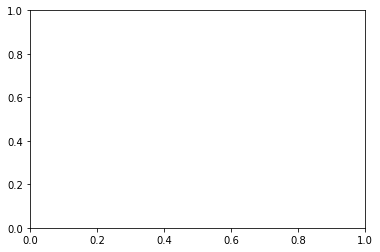

In [1]:
import pandas as pd
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from navipy.trajectories import Trajectory
from navipy.errorprop import propagate_error
import tqdm
import multiprocessing
import os

## Velocities

We want to calculate the velocities of the flights in the flight's coordinate system. Velocities are the derivaties of position and orientation of the flight over time. Taking the derivatives usually increase the noise. Thus, we will first filter the position and orientation with cspline1d filter, and then calculate the velocity.

### Where are the data

The flight trajectories are stored in hdf files

In [2]:
# Load list of flights
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
flight_ids = pd.read_hdf(head_filename_result,key='flight_ids')
# Load the results from splitted nonans
head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5'

In [3]:
with pd.HDFStore(head_filename_result) as hdf:
    print(hdf.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/Processed/head_thorax_data.h5
/errors/flight_05                  frame                    
/errors/flight_06                  frame                    
/errors/flight_07                  frame                    
/errors/flight_08                  frame                    
/errors/flight_11                  frame                    
/errors/flight_17                  frame                    
/flight_ids                        series       (shape->[1])
/trajectories/flight_05            frame                    
/trajectories/flight_06            frame                    
/trajectories/flight_07            frame                    
/trajectories/flight_08            frame                    
/trajectories/flight_11            frame                    
/trajectories/flight_17            frame                    


#### Example

In [4]:
flightid = '17'
assert flightid in flight_ids.values, 'flight id unknwon'

blk_i = 0
key = '/blk_nonans/flight_{}'.format(flightid) 
blknonans = pd.read_hdf(head_filename_result_blocknonans,key)

assert blk_i in blknonans.index, 'Block unknown'

1. Load the data

In [5]:
key = '/trajectories/flight_{}/blk_{}'.format(flightid,blk_i) 
traj = pd.read_hdf(head_filename_result_blocknonans,key)
body_traj = traj.loc[:,'thorax']
body_traj = Trajectory().from_dataframe(body_traj)
head_traj = traj.loc[:,'head']
head_traj = Trajectory().from_dataframe(head_traj)
# The error
key = '/errors/flight_{}/blk_{}'.format(flightid,blk_i) 
error = pd.read_hdf(head_filename_result_blocknonans,key)
body_traj.trajectory_error = error.loc[:,'thorax']
head_traj.trajectory_error = error.loc[:,'head']
head_traj.head()

location                        zyx                      
             x        y        z  alpha_0    alpha_1    alpha_2
336.0   10.893 -56.9974  27.4807 -2.45589 -0.0876755 -0.0759232
337.0   10.701 -56.6263  27.6258 -2.44168  -0.113219  -0.100047
338.0  10.5024 -56.3755  27.7349 -2.45523   -0.16144 -0.0512822
339.0   6.8979 -55.4645   24.926 -2.48773  -0.226464  -0.110377
340.0  6.75246  -55.069  25.1401 -2.43568  -0.196439  -0.126913

Trajectory are location (position) and zyx (orientation) over frame

In [6]:
head_traj.trajectory_error.head()

location                                                         zyx  \
              x              y                   z                  alpha_0   
              x    y    z    x         y    z    x    y         z   alpha_0   
336.0  0.002469  0.0  0.0  0.0  0.002469  0.0  0.0  0.0  0.002469  0.001737   
337.0  0.003510  0.0  0.0  0.0  0.003510  0.0  0.0  0.0  0.003510  0.002541   
338.0  0.002386  0.0  0.0  0.0  0.002386  0.0  0.0  0.0  0.002386  0.001586   
339.0  0.005673  0.0  0.0  0.0  0.005673  0.0  0.0  0.0  0.005673  0.004281   
340.0  0.008008  0.0  0.0  0.0  0.008008  0.0  0.0  0.0  0.008008  0.005754   

                                                                             \
                            alpha_1                       alpha_2             
        alpha_1   alpha_2   alpha_0   alpha_1   alpha_2   alpha_0   alpha_1   
336.0  0.000164  0.000118  0.000164  0.003858 -0.000431  0.000118 -0.000431   
337.0  0.000260  0.000224  0.000260  0.005055 -0.000592  0.000224 -0.000592   
338.0  0.000088  0.000241  0.000088  0.003239 -0.000255  0.000241 -0.000255   
339.0  0.000439  0.000907  0.000439  0.007876 -0.000375  0.000907 -0.000375   
340.0  0.000617  0.001066  0.000617  0.010196 -0.000322  0.001066 -0.000322   

                 
                 
        alpha_2  
336.0  0.001718  
337.0  0.002501  
338.0  0.001577  
339.0  0.004209  
340.0  0.005654

Error are variance-covariance matrix

2. Filter the body trajectory

Note navipy is propagating the error when head_traj.trajectory_error is not None.

In [7]:
body_traj.filt_cspline(lamb=pd.Series(data=150, index=body_traj.columns))
head_traj.filt_cspline(lamb=pd.Series(data=150, index=head_traj.columns))

/home/bolirev/.virtualenv/exp-2019-ESNPred/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/bolirev/.virtualenv/exp-2019-ESNPred/lib/python3.6/site-packages/navipy-0.1.2-py3.6.egg/navipy/trajectories/__init__.py:945: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
head_traj.trajectory_error.head()

location                                                         zyx  \
              x              y                   z                  alpha_0   
              x    y    z    x         y    z    x    y         z   alpha_0   
336.0  0.000029  0.0  0.0  0.0  0.000029  0.0  0.0  0.0  0.000029  0.000021   
337.0  0.000093  0.0  0.0  0.0  0.000093  0.0  0.0  0.0  0.000093  0.000067   
338.0  0.000033  0.0  0.0  0.0  0.000033  0.0  0.0  0.0  0.000033  0.000023   
339.0  0.000047  0.0  0.0  0.0  0.000047  0.0  0.0  0.0  0.000047  0.000035   
340.0  0.000050  0.0  0.0  0.0  0.000050  0.0  0.0  0.0  0.000050  0.000036   

                                                                             \
                            alpha_1                       alpha_2             
        alpha_1   alpha_2   alpha_0   alpha_1   alpha_2   alpha_0   alpha_1   
336.0  0.000002  0.000001  0.000002  0.000045 -0.000005  0.000001 -0.000005   
337.0  0.000007  0.000006  0.000007  0.000134 -0.000016  0.000006 -0.000016   
338.0  0.000002  0.000003  0.000002  0.000046 -0.000004  0.000003 -0.000004   
339.0  0.000004  0.000007  0.000004  0.000065 -0.000003  0.000007 -0.000003   
340.0  0.000004  0.000007  0.000004  0.000065 -0.000002  0.000007 -0.000002   

                 
                 
        alpha_2  
336.0  0.000020  
337.0  0.000066  
338.0  0.000022  
339.0  0.000035  
340.0  0.000036

We see that the variance-covariance are roughly divided by 100 :)

3. Calc velocity

Note navipy also propagate the error here :)

In [9]:
body_velocity, body_velocity_error = body_traj.velocity(frame='body')
head_velocity, head_velocity_error = head_traj.velocity(frame='body')

In [10]:
head_velocity.head()

location                           zyx                    
             dx        dy        dz  dalpha_0  dalpha_1  dalpha_2
336.0       NaN       NaN       NaN       NaN       NaN       NaN
337.0  0.034958 -0.137563 -0.009822  0.002201  0.000851 -0.000372
338.0  0.064183 -0.259741 -0.015084  0.003892  0.001423 -0.000834
339.0  0.080112 -0.355711 -0.009077  0.005027  0.001568 -0.001257
340.0  0.077397 -0.417049  0.012188  0.005514  0.001429 -0.001672

We can merge the results to have trajectories_filtered and errors filtered respectively

In [11]:
trajectories_filtered = pd.concat([pd.DataFrame(head_traj), 
                                   pd.DataFrame(body_traj)], 
                                   axis=1, keys = ['head','thorax'])
trajectories_filtered.head()

head                                                   thorax  \
      location                        zyx                      location   
             x        y        z  alpha_0   alpha_1    alpha_2        x   
336.0  8.95172 -56.0592  26.4512 -2.45272 -0.156582 -0.0965675  14.0842   
337.0  8.84032 -55.9783  26.4154 -2.45327 -0.158637 -0.0977418  13.9799   
338.0   8.6312 -55.8239  26.3501 -2.45445 -0.162206 -0.0998764  13.7841   
339.0   8.3495 -55.6062  26.2708  -2.4562 -0.166602  -0.102817  13.5205   
340.0  8.02887 -55.3377  26.1989 -2.45845 -0.171191  -0.106241  13.2217   

                                                       
                             zyx                       
             y        z  alpha_0    alpha_1   alpha_2  
336.0 -61.2935  27.5616 -2.38775  0.0928134  0.169754  
337.0 -61.2138  27.5243 -2.38627  0.0973643  0.169297  
338.0 -61.0611   27.456 -2.38357   0.105883  0.168262  
339.0 -60.8452  27.3712 -2.38014   0.117672  0.166725  
340.0 -60.5786   27.291 -2.37646   0.131794   0.16481

In [12]:
errors_filtered = pd.concat([pd.DataFrame(head_traj.trajectory_error), 
                             pd.DataFrame(body_traj.trajectory_error)], 
                             axis=1, keys = ['head','thorax'])
errors_filtered.head()

head                                                              \
       location                                                         zyx   
              x              y                   z                  alpha_0   
              x    y    z    x         y    z    x    y         z   alpha_0   
336.0  0.000029  0.0  0.0  0.0  0.000029  0.0  0.0  0.0  0.000029  0.000021   
337.0  0.000093  0.0  0.0  0.0  0.000093  0.0  0.0  0.0  0.000093  0.000067   
338.0  0.000033  0.0  0.0  0.0  0.000033  0.0  0.0  0.0  0.000033  0.000023   
339.0  0.000047  0.0  0.0  0.0  0.000047  0.0  0.0  0.0  0.000047  0.000035   
340.0  0.000050  0.0  0.0  0.0  0.000050  0.0  0.0  0.0  0.000050  0.000036   

       ...    thorax                                                      \
       ...  location       zyx                                             
       ...         z   alpha_0                                   alpha_1   
       ...         z   alpha_0       alpha_1       alpha_2       alpha_0   
336.0  ...  0.000029  0.000010 -6.640117e-07 -4.468869e-07 -6.640117e-07   
337.0  ...  0.000093  0.000034 -2.186975e-06 -2.415245e-06 -2.186975e-06   
338.0  ...  0.000033  0.000012 -7.661518e-07 -8.806562e-07 -7.661518e-07   
339.0  ...  0.000047  0.000019 -9.402696e-07 -2.736105e-06 -9.402696e-07   
340.0  ...  0.000050  0.000020 -1.196805e-06 -2.876046e-06 -1.196805e-06   

                                                                     
                                                                     
                                    alpha_2                          
        alpha_1       alpha_2       alpha_0       alpha_1   alpha_2  
336.0  0.000014  7.625669e-07 -4.468869e-07  7.625669e-07  0.000010  
337.0  0.000045  2.245839e-06 -2.415245e-06  2.245839e-06  0.000033  
338.0  0.000016  1.408521e-06 -8.806562e-07  1.408521e-06  0.000012  
339.0  0.000024  1.088078e-06 -2.736105e-06  1.088078e-06  0.000019  
340.0  0.000027  1.846423e-06 -2.876046e-06  1.846423e-06  0.000020  

[5 rows x 36 columns]

In [13]:
velocities_filtered = pd.concat([pd.DataFrame(head_velocity), 
                                 pd.DataFrame(body_velocity)], 
                                 axis=1, keys = ['head','thorax'])
velocities_filtered.head()

head                                                      thorax  \
       location                           zyx                      location   
             dx        dy        dz  dalpha_0  dalpha_1  dalpha_2        dx   
336.0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
337.0  0.034958 -0.137563 -0.009822  0.002201  0.000851 -0.000372  0.022423   
338.0  0.064183 -0.259741 -0.015084  0.003892  0.001423 -0.000834  0.038660   
339.0  0.080112 -0.355711 -0.009077  0.005027  0.001568 -0.001257  0.042188   
340.0  0.077397 -0.417049  0.012188  0.005514  0.001429 -0.001672  0.028918   

                                                         
                                zyx                      
             dy        dz  dalpha_0  dalpha_1  dalpha_2  
336.0       NaN       NaN       NaN       NaN       NaN  
337.0 -0.120403 -0.060005 -0.002788 -0.003625  0.001434  
338.0 -0.228124 -0.113142 -0.005109 -0.006893  0.002586  
339.0 -0.314859 -0.149541 -0.007029 -0.009587  0.003251  
340.0 -0.374241 -0.161041 -0.008412 -0.011501  0.003436

In [14]:
errors_velocities_filtered = pd.concat([pd.DataFrame(head_velocity_error), 
                                 pd.DataFrame(body_velocity_error)], 
                                 axis=1, keys = ['head','thorax'])
errors_velocities_filtered.head()

head                                                                \
       location                                                                 
             dx                                                                 
             dx        dy        dz      dalpha_0      dalpha_1      dalpha_2   
336.0       NaN       NaN       NaN           NaN           NaN           NaN   
337.0  0.000078  0.000031 -0.000002 -8.139315e-09 -1.846538e-09 -3.107211e-09   
338.0  0.000028  0.000011 -0.000001 -8.433477e-09 -1.871858e-09 -3.652338e-09   
339.0  0.000043  0.000015 -0.000004 -1.973785e-08 -4.165213e-09 -1.097500e-08   
340.0  0.000045  0.000014 -0.000003 -2.146638e-08 -4.380905e-09 -1.358812e-08   

                                                   ...        thorax  \
                                                   ...           zyx   
             dy                                    ...      dalpha_1   
             dx        dy        dz      dalpha_0  ...            dz   
336.0       NaN       NaN       NaN           NaN  ...           NaN   
337.0  0.000031  0.000122 -0.000010  2.045639e-08  ... -9.003821e-10   
338.0  0.000011  0.000040 -0.000002  2.249825e-08  ... -1.451214e-09   
339.0  0.000015  0.000056 -0.000002  6.154940e-08  ... -3.987495e-09   
340.0  0.000014  0.000055 -0.000003  8.125896e-08  ... -6.138590e-09   

                                                                         \
                                                                          
                                                 dalpha_2                 
           dalpha_0  dalpha_1      dalpha_2            dx            dy   
336.0           NaN       NaN           NaN           NaN           NaN   
337.0  7.135844e-08  0.000094 -3.046008e-07 -1.265766e-09  9.479078e-10   
338.0  7.709941e-08  0.000033 -4.093834e-07 -1.560658e-09  1.104265e-09   
339.0  2.226296e-07  0.000048 -1.066697e-06 -6.611898e-09  4.671773e-09   
340.0  1.675637e-07  0.000051 -1.530407e-06 -1.060260e-08  7.423468e-09   

                                                           
                                                           
                                                           
                 dz      dalpha_0      dalpha_1  dalpha_2  
336.0           NaN           NaN           NaN       NaN  
337.0  2.082364e-09  7.654215e-08 -3.046008e-07  0.000094  
338.0  3.310465e-09  1.022187e-07 -4.093834e-07  0.000034  
339.0  9.349258e-09  1.624572e-07 -1.066697e-06  0.000049  
340.0  1.513662e-08  1.970898e-07 -1.530407e-06  0.000054  

[5 rows x 72 columns]

## On all data

In [15]:
def process(inputs):
    # unwrap inputs
    flightid, blk_i = inputs
    # 1-Load data
    key = '/trajectories/flight_{}/blk_{}'.format(flightid,blk_i) 
    traj = pd.read_hdf(head_filename_result_blocknonans,key)
    body_traj = traj.loc[:,'thorax']
    body_traj = Trajectory().from_dataframe(body_traj)
    head_traj = traj.loc[:,'head']
    head_traj = Trajectory().from_dataframe(head_traj)
    # The error
    key = '/errors/flight_{}/blk_{}'.format(flightid,blk_i) 
    error = pd.read_hdf(head_filename_result_blocknonans,key)
    body_traj.trajectory_error = error.loc[:,'thorax']
    head_traj.trajectory_error = error.loc[:,'head']
    head_traj.head()

    # 2- Filter
    body_traj.filt_cspline(lamb=pd.Series(data=150, index=body_traj.columns))
    head_traj.filt_cspline(lamb=pd.Series(data=150, index=head_traj.columns))

    # 3- Velocities
    body_velocity, body_velocity_error = body_traj.velocity(frame='body')
    head_velocity, head_velocity_error = head_traj.velocity(frame='body')
    
    # 4- Concat
    trajectories_filtered = pd.concat([pd.DataFrame(head_traj), 
                                   pd.DataFrame(body_traj)], 
                                   axis=1, keys = ['head','thorax'])
    # error
    errors_filtered = pd.concat([pd.DataFrame(head_traj.trajectory_error), 
                     pd.DataFrame(body_traj.trajectory_error)], 
                     axis=1, keys = ['head','thorax'])
    # velocities_filtered
    velocities_filtered = pd.concat([pd.DataFrame(head_velocity), 
                         pd.DataFrame(body_velocity)], 
                         axis=1, keys = ['head','thorax'])
    # errors_velocities_filtered
    errors_velocities_filtered = pd.concat([pd.DataFrame(head_velocity_error), 
                             pd.DataFrame(body_velocity_error)], 
                             axis=1, keys = ['head','thorax'])
    return (flightid, blk_i, trajectories_filtered, errors_filtered, velocities_filtered, errors_velocities_filtered)

List all blocks with their corresponding flight id

In [16]:
inputs = []
for flightid in flight_ids.values:
    key = '/blk_nonans/flight_{}'.format(flightid) 
    blknonans = pd.read_hdf(head_filename_result_blocknonans,key)
    for blk_i in blknonans.index:
        inputs.append((flightid, blk_i))

Loop through all rec

In [17]:
pool = multiprocessing.Pool()
results = list()
# This will show the progress
for res in tqdm.tqdm(pool.imap_unordered(process, inputs), total=len(inputs)):
    results.append(res)
pool.close()
pool.join()
# Save the results after themultiprocessing
# because we cannot read and save in threadsafe manner (without locks)
for res in results:
    flightid, blk_i, trajectories_filtered, errors_filtered, velocities_filtered, errors_velocities_filtered = res 
    # 4 - Save
    with pd.HDFStore(head_filename_result_blocknonans, 'a') as hdf:
        key = '/trajectories_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
        hdf.put(key, trajectories_filtered.astype(float))
        key = '/errors_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
        hdf.put(key, errors_filtered.astype(float))
        key = '/velocities_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
        hdf.put(key, velocities_filtered.astype(float))
        key = '/errors_velocities_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
        hdf.put(key, errors_velocities_filtered.astype(float))

100%|██████████| 22/22 [06:49<00:00, 18.63s/it]
